In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
import tqdm

In [156]:
disk_loc = "/media/jdtho/shiner/v1/scans/"
ignore_objects = {'ceiling', 'delete', 'floor', 'light',
                  'remove', 'roof', 'wall',
                  'wall frame', 'window frame', 'windowsill'}
# if this appears anywhere in the object name, remove it
ignore_objects_with_substr = {'/', 'frame', 'object', 'other room', 'unknown',
                              'behind', 'rail', 'arch'}
# if this appear as a token in obj name, remove them.
strip_words = {'kitchen', 'bath', 'bathroom', 'ceiling', 'wall', 'closet'}
# replace the key obj w value obj.
rename_objs = {'bin': 'trashcan', 'trash': 'trashcan', 'trashbin': 'trashcan',
               'shelving': 'shelf', 'countertop': 'counter',
               'smokealarm': 'firealarm', 'smokedetector': 'firealarm',
               'massagebed': 'bed',
               'couch': 'sofa', 'flowerpot': 'pot', 'plantpot': 'pot',
               'computerdesk': 'desk', 'tree': 'plant', 'oven': 'stove',
               'radiator': 'heater', 'flower': 'plant', 'pottedplant': 'plant',
               'bust': 'statue', 'commode': 'toilet', 'refrigerator': 'fridge',
               'coathanger': 'hanger', 'laptop': 'computer', 'monitor': 'screen',
               'footrest': 'ottoman', 'papertoweldispenser': 'papertowel',
               'sculpture': 'statue', 'exitsign': 'sign', 'tap': 'sink',
               'tissuebox': 'tissues', 'tissuepaper': 'tissues',
               'toiletpaperdispenser': 'toiletpaper', 'stuffedanimal': 'toy',
               'urn': 'vase', 'vanity': 'mirror', 'bookshelf': 'bookcase',
               'bowloffruit': 'bowl', 'toiletpaperholder': 'toiletpaper'}
# if these appear in obj name, replace obj name w base.
base_words = {'chair', 'sofa', 'stool', 'table', 'shower', 'soap', 'candle'}

# Objects that are, like, fine, but maybe weird as targets due to
# massive ambiguity or awkwardness of "take a photo of X" or 
# being too general (e.g., 'art').
non_target_objects = {'door', 'window', 'mirror', 'cabinet', 'fan', 'washbasin', 'stair',
                      'closet', 'furniture', 'step', 'decoration', 'blanket', 'pedestal',
                      'headboard', 'clutter', 'bench', 'drawer', 'switch', 'pillar', 'art',
                      'blind', 'toiletry', 'tvstand', 'column', 'bar', 'baracade',
                      'beam', 'board', 'carpet', 'celing', 'cloth', 'clothe', 'container',
                      'control', 'counter', 'cup', 'cupboard', 'curtain', 'curtainrod',
                      'decor', 'doorhandle', 'doorstopper', 'doorway', 'duct', 'fence',
                      'flower', 'garagedoor', 'garagedooropener', 'glas', 'gras', 'hood',
                      'lampshade', 'keyboard', 'ledge', 'light', 'lightfixture',
                      'lightswitch', 'molding', 'moulding', 'painter', 'panel', 'post',
                      'rack', 'rope', 'seat', 'shelf', 'slidingdoor', 'speaker', 'stand',
                      'table', 'thermostat', 'towelbar', 'tray', 'utencil', 'vent',
                      'wainscotting', 'whiteboard', 'windowcurtain', 'windowshade',
                      'windowsill', 'soffet', 'chair', 'shower', 'bathtub'}

In [157]:
houses = []
for root, dirs, files in os.walk(disk_loc):
    for d in dirs:
        houses.append(d)
    break  # only index top level

In [158]:
# Generate dict from houses to objs to regions to lists of sizes in that region.
# TODO: could add a minimum number of segments of objects are too low-visibility later on.
p2r = {}
house_obj_data = {}  # map from house to object seg info.
all_objs = []
for house in tqdm.tqdm(houses):
    house_obj_data[house] = {}
    
    # Create panorama-to-region map.
    p2r[house] = {}
    p2r_fn = os.path.join(disk_loc, house, house,
                          "house_segmentations", "panorama_to_region.txt")
    if not os.path.isfile(p2r_fn):
        zip_fn = os.path.join(disk_loc, house, "house_segmentations.zip")
        os.system("unzip -o %s -d %s" % (zip_fn, os.path.join(disk_loc, house)))
    with open(p2r_fn, 'r') as f:
        for line in f.readlines():
            _, pid, rid, _ = line.strip().split()
            if int(rid) >= 0:  # discard "-1" regions.
                p2r[house][pid] = rid
    
    # For every region, read in object data and populate structure.
    regions = set(p2r[house].values())
    for rid in regions:
        reg_seg_fn = os.path.join(disk_loc, house, house,
                                  "region_segmentations", "region%s.semseg.json" % rid)
        if not os.path.isfile(reg_seg_fn):
            zip_fn = os.path.join(disk_loc, house, "region_segmentations.zip")
            os.system("unzip -o %s -d %s" % (zip_fn, os.path.join(disk_loc, house)))
        with open(reg_seg_fn, 'r') as f:
            json_str = f.read()
            json_str = json_str.replace("\o", "/ o")
            d = json.loads(json_str)
        for seg in d["segGroups"]:
            obj = seg["label"]
            if np.any([sub in obj for sub in ignore_objects_with_substr]):
                continue
            if obj in ignore_objects:
                continue
            tks = obj.split()
            obj = ''
            # Remove spaces and strip words.
            for tk in tks:
                if tk not in strip_words:
                    obj += tk
            if len(obj) == 0:
                continue
            # Rename if necessary.
            if obj in rename_objs:
                obj = rename_objs[obj]
            # Reduce to base word if necessary.
            for base in base_words:
                if base in obj:
                    obj = base
                    break
            # Lemmatize.
            lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
            obj = lemmatizer(obj, u"NOUN")[0]
            size = len(seg["segments"])
            # If object is in our list of non-targets, skip.
            if obj in non_target_objects:
                continue
            
            # Add to house obj structure.
            if obj not in all_objs:
                all_objs.append(obj)
            if obj not in house_obj_data[house]:
                house_obj_data[house][obj] = {}
            if rid not in house_obj_data[house][obj]:
                house_obj_data[house][obj][rid] = []
            house_obj_data[house][obj][rid].append(size)

100%|██████████| 90/90 [00:05<00:00, 15.01it/s]


In [159]:
# Recreate the structure after eliminating objects that do not appear more than
# a threshold of times or are not sufficiently ambiguous within the houses in which they
# appear.
total_across_houses_thresh = 5  # e.g., >5% of houses (out of 90).
total_within_house_thresh = [2, 3]  # at least two, at most four

# Total count.
counts = {}
for obj in all_objs:
    r = 0
    for house in houses:
        if obj in house_obj_data[house]:
            r += len(house_obj_data[house][obj])
    counts[obj] = r

# Trim by ambiguity.
trimmed_house_obj_data = {}
orig_obj_count = len(all_objs)
all_objs = []
for house in houses:
    trimmed_house_obj_data[house] = {}
    for obj in house_obj_data[house]:
        if counts[obj] >= total_across_houses_thresh:
            amb_level = len(house_obj_data[house][obj])
            if total_within_house_thresh[0] <= amb_level <= total_within_house_thresh[1]:
                trimmed_house_obj_data[house][obj] = house_obj_data[house][obj]
                if obj not in all_objs:
                    all_objs.append(obj)

print("trimmed from %d unique objects to %d" % (orig_obj_count, len(all_objs)))
house_obj_data = trimmed_house_obj_data

print("new object list: " + str(sorted(all_objs)))

trimmed from 929 unique objects to 81
new object list: ['airconditioner', 'basin', 'basket', 'bed', 'book', 'bookcase', 'bottle', 'bowl', 'box', 'bucket', 'candle', 'chandelier', 'chest', 'chestofdrawer', 'chimney', 'clock', 'clothesdryer', 'coatrack', 'computer', 'cushion', 'desk', 'dishwasher', 'displaycase', 'doll', 'dresser', 'easel', 'faucet', 'firealarm', 'fireextinguisher', 'fireplace', 'floorlamp', 'fridge', 'guitar', 'hanger', 'heater', 'ladder', 'lamp', 'mat', 'microwave', 'nightstand', 'ottoman', 'painting', 'papertowel', 'phone', 'photo', 'piano', 'picture', 'pillow', 'pipe', 'plant', 'plate', 'pool', 'pot', 'rug', 'scale', 'sconce', 'screen', 'shampoo', 'shoe', 'sign', 'sink', 'skylight', 'soap', 'sofa', 'statue', 'stool', 'stove', 'teapot', 'telephone', 'tissue', 'toilet', 'toiletbrush', 'toiletpaper', 'towel', 'toy', 'trashcan', 'tv', 'vase', 'wardrobe', 'washingmachine', 'watercooler']


In [160]:
# Convert to house -> object -> regions
r2p = {}
for house in houses:
    r2p[house] = {}
    for p in p2r[house]:
        rid = p2r[house][p]
        if rid not in r2p[house]:
            r2p[house][rid] = []
        r2p[house][rid].append(p)

house_obj_regions = {}
for house in houses:
    house_obj_regions[house] = {}
    for obj in house_obj_data[house]:
        house_obj_regions[house][obj] = list(house_obj_data[house][obj].keys())
        
with open('resources/house_obj_regions.json', 'w') as f:
    json.dump(house_obj_regions, f)
with open('resources/house_region_to_panorama.json', 'w') as f:
    json.dump(r2p, f)

0.378(34/90): bed
0.367(33/90): nightstand
0.356(32/90): stool
0.333(30/90): towel
0.311(28/90): sofa
0.311(28/90): toilet
0.278(25/90): tv
0.256(23/90): lamp
0.244(22/90): sink
0.244(22/90): trashcan
0.244(22/90): vase
0.244(22/90): desk
0.233(21/90): pot
0.200(18/90): pillow
0.200(18/90): dresser
0.200(18/90): book
0.189(17/90): statue
0.189(17/90): fireplace
0.189(17/90): plant
0.156(14/90): toiletpaper
0.144(13/90): picture
0.133(12/90): fridge
0.122(11/90): bottle
0.122(11/90): rug
0.122(11/90): ottoman
0.111(10/90): box
0.111(10/90): painting
0.111(10/90): screen
0.100(9/90): cushion
0.100(9/90): faucet
0.100(9/90): bookcase
0.089(8/90): stove
0.089(8/90): soap
0.089(8/90): chest
0.078(7/90): wardrobe
0.078(7/90): bowl
0.078(7/90): photo
0.067(6/90): clock
0.067(6/90): papertowel
0.067(6/90): telephone
0.056(5/90): candle
0.056(5/90): bucket
0.056(5/90): tissue
0.056(5/90): microwave
0.044(4/90): pipe
0.044(4/90): basket
0.044(4/90): fireextinguisher
0.044(4/90): mat
0.033(3/90):

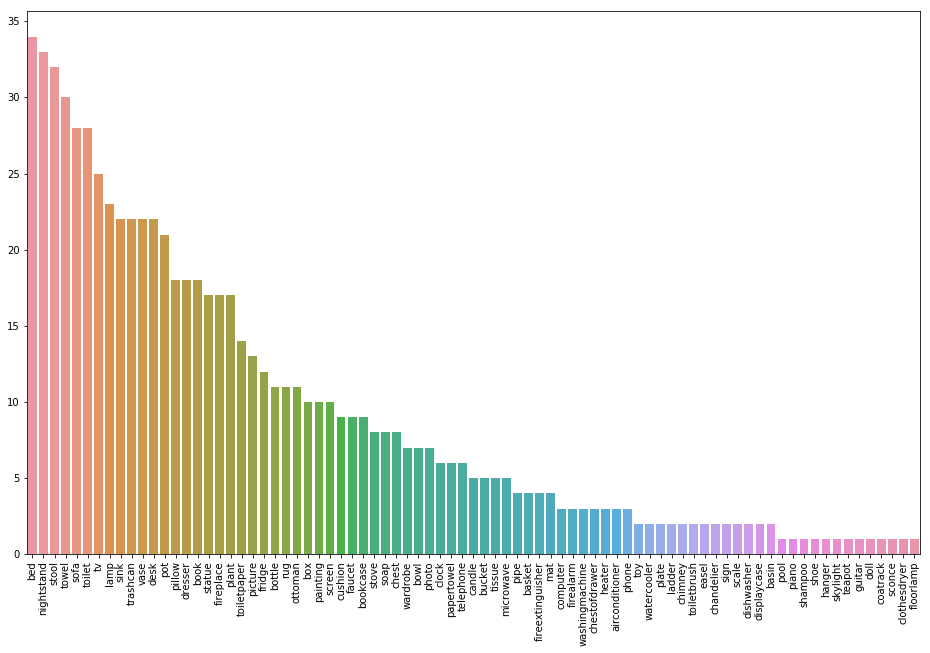

In [167]:
counts = {}
for house in houses:
    for obj in house_obj_data[house]:
        amb_level = len(house_obj_data[house][obj])
        if obj not in counts:
            counts[obj] = 0
        counts[obj] += 1

ordered = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print('\n'.join(["%.3f(%d/%d): %s" % (c / float(len(houses)), c, len(houses), o)
                 for o, c in ordered]))

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax, x=[o[0] for o in ordered], y=[o[1] for o in ordered],
               order=[o[0] for o in ordered])
# ax.set(yscale="log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

87: bed
80: nightstand
77: stool
72: towel
69: toilet
68: sofa
62: tv
55: sink
55: lamp
53: trashcan
52: vase
49: desk
47: pot
44: pillow
43: book
42: fireplace
41: dresser
40: statue
37: plant
34: toiletpaper
30: picture
28: ottoman
27: fridge
26: rug
25: bottle
23: box
22: screen
21: painting
21: faucet
20: soap
19: cushion
19: chest
18: bookcase
17: stove
16: bowl
15: wardrobe
14: photo
14: papertowel
13: clock
12: basket
12: telephone
11: candle
11: bucket
11: tissue
10: microwave
9: pipe
9: fireextinguisher
9: mat
6: computer
6: firealarm
6: washingmachine
6: chestofdrawer
6: heater
6: airconditioner
6: phone
5: watercooler
5: sign
5: displaycase
4: toy
4: plate
4: ladder
4: chimney
4: toiletbrush
4: easel
4: chandelier
4: scale
4: dishwasher
4: basin
3: skylight
2: pool
2: piano
2: shampoo
2: shoe
2: hanger
2: teapot
2: guitar
2: doll
2: coatrack
2: sconce
2: clothesdryer
2: floorlamp


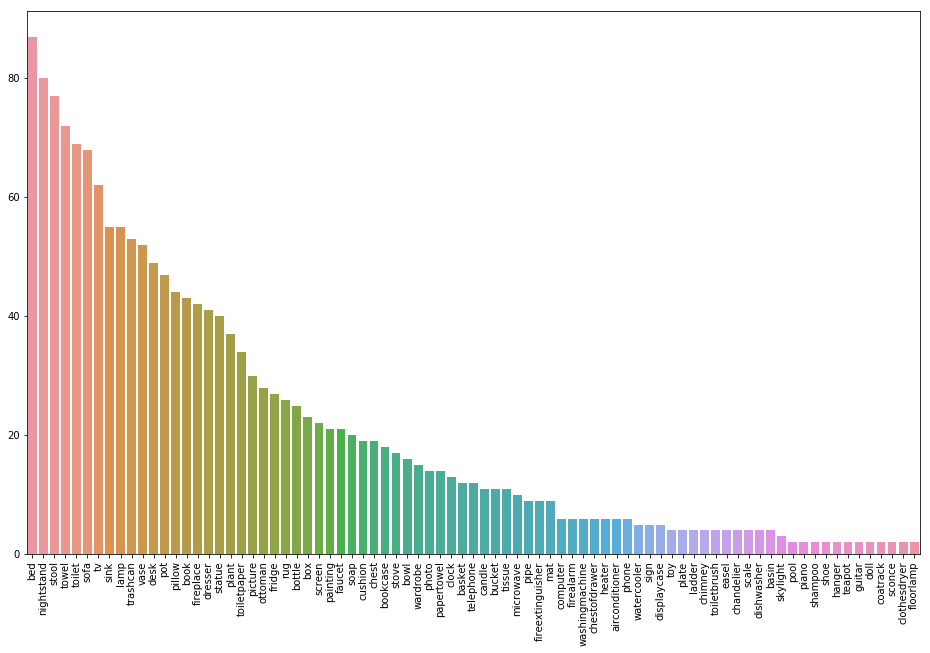

In [166]:
counts = {}
for obj in all_objs:
    r = 0
    for house in houses:
        if obj in house_obj_data[house]:
            r += len(house_obj_data[house][obj])
    counts[obj] = r
    
ordered = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print('\n'.join([str(c) + ": " + o for o, c in ordered]))

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax, x=[o[0] for o in ordered], y=[o[1] for o in ordered],
               order=[o[0] for o in ordered])
# ax.set(yscale="log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [163]:
# Unzip skybox images.
for house in tqdm.tqdm(houses):
    skybox_dir = os.path.join(disk_loc, house, "matterport_skybox_images")
    print(skybox_dir)
    if not os.path.isdir(skybox_dir):
        zip_fn = os.path.join(disk_loc, house, "matterport_skybox_images.zip")
        os.system("unzip -o %s -d %s" % (zip_fn, disk_loc))

100%|██████████| 90/90 [00:00<00:00, 14143.93it/s]

/media/jdtho/shiner/v1/scans/JmbYfDe2QKZ/matterport_skybox_images
/media/jdtho/shiner/v1/scans/gZ6f7yhEvPG/matterport_skybox_images
/media/jdtho/shiner/v1/scans/WYY7iVyf5p8/matterport_skybox_images
/media/jdtho/shiner/v1/scans/rqfALeAoiTq/matterport_skybox_images
/media/jdtho/shiner/v1/scans/UwV83HsGsw3/matterport_skybox_images
/media/jdtho/shiner/v1/scans/mJXqzFtmKg4/matterport_skybox_images
/media/jdtho/shiner/v1/scans/ur6pFq6Qu1A/matterport_skybox_images
/media/jdtho/shiner/v1/scans/rPc6DW4iMge/matterport_skybox_images
/media/jdtho/shiner/v1/scans/D7G3Y4RVNrH/matterport_skybox_images
/media/jdtho/shiner/v1/scans/RPmz2sHmrrY/matterport_skybox_images
/media/jdtho/shiner/v1/scans/sKLMLpTHeUy/matterport_skybox_images
/media/jdtho/shiner/v1/scans/s8pcmisQ38h/matterport_skybox_images
/media/jdtho/shiner/v1/scans/q9vSo1VnCiC/matterport_skybox_images
/media/jdtho/shiner/v1/scans/82sE5b5pLXE/matterport_skybox_images
/media/jdtho/shiner/v1/scans/e9zR4mvMWw7/matterport_skybox_images
/media/jdt

In [164]:
# Move precomputed policies and clean up.
for house in tqdm.tqdm(houses):
    policies_dir = os.path.join("/media/jdtho/shiner/", house, "policies")
    target_dir = os.path.join(disk_loc, house)
    cmd = "mv %s %s" % (policies_dir, target_dir)
    os.system(cmd)
    leftover_dir = os.path.join("/media/jdtho/shiner/", house)
    cmd = "rm -r %s" % leftover_dir
    os.system(cmd)

100%|██████████| 90/90 [00:02<00:00, 33.98it/s]


In [165]:
houses

['JmbYfDe2QKZ',
 'gZ6f7yhEvPG',
 'WYY7iVyf5p8',
 'rqfALeAoiTq',
 'UwV83HsGsw3',
 'mJXqzFtmKg4',
 'ur6pFq6Qu1A',
 'rPc6DW4iMge',
 'D7G3Y4RVNrH',
 'RPmz2sHmrrY',
 'sKLMLpTHeUy',
 's8pcmisQ38h',
 'q9vSo1VnCiC',
 '82sE5b5pLXE',
 'e9zR4mvMWw7',
 'qoiz87JEwZ2',
 'Uxmj2M2itWa',
 'x8F5xyUWy9e',
 'kEZ7cmS4wCh',
 'pLe4wQe7qrG',
 'HxpKQynjfin',
 'X7HyMhZNoso',
 'zsNo4HB9uLZ',
 'ARNzJeq3xxb',
 'PuKPg4mmafe',
 'JF19kD82Mey',
 'VVfe2KiqLaN',
 'V2XKFyX4ASd',
 'ULsKaCPVFJR',
 'gTV8FGcVJC9',
 '1LXtFkjw3qL',
 '2t7WUuJeko7',
 '1pXnuDYAj8r',
 'wc2JMjhGNzB',
 'fzynW3qQPVF',
 'jh4fc5c5qoQ',
 'D7N2EKCX4Sj',
 'Z6MFQCViBuw',
 'VLzqgDo317F',
 '2n8kARJN3HM',
 '2azQ1b91cZZ',
 'vyrNrziPKCB',
 'QUCTc6BB5sX',
 '759xd9YjKW5',
 'XcA2TqTSSAj',
 'SN83YJsR3w2',
 'r1Q1Z4BcV1o',
 'oLBMNvg9in8',
 'YmJkqBEsHnH',
 '5LpN3gDmAk7',
 'B6ByNegPMKs',
 'sT4fr6TAbpF',
 'YVUC4YcDtcY',
 'dhjEzFoUFzH',
 'GdvgFV5R1Z5',
 'VzqfbhrpDEA',
 'ZMojNkEp431',
 'gYvKGZ5eRqb',
 '17DRP5sb8fy',
 'TbHJrupSAjP',
 'EDJbREhghzL',
 'ac26ZMwG7aT',
 'r47D5H